EE364b Convex Optimization II, S. Boyd

Written by Shuvomoy Das Gupta

---------------------

We consider the implementation of alternate subgradient method which solves the following optimization problem:

$$
\begin{align}
&\textrm{minimize} \quad f_0(x) \\
&\textrm{subject to} \quad \forall i \in \{1,\ldots,m\} \quad f_i(x)\leq0,
\end{align}
$$

where $f_i:\mathbb{R}^n \rightarrow \mathbb{R}$ are convex. The update rule is the same as seen before:

$$
\begin{align}
x^{(k+1)}=x^{(k)}-\alpha_{k} g^{(k)},
\end{align}
$$

however, now $g^{(k)}$ will depend on the feasibility of the current point $x^{k}$. Suppose,
$h(x)=\textrm{max}_{i \in \{1,\ldots,m\}}{f_i(x)}$. Then,

$$
\begin{align}
g^{(k)}=\begin{cases}
 \partial f_0(x^{(k)}), \; &\textrm{if} \; h(x^{(k)})\leq0, \; \textrm{i.e.,} \; x^{(k)} \; \textrm{feasible}\\
\partial h(x^{(k)}) \; &\textrm{else}.
\end{cases}
\end{align}
$$

The step lengths are chosen as

$$
\begin{align}
\alpha_k=\begin{cases}
 (f_0(x^{(k)})-f^*)/\|g^{(k)}\|_2^2, \; &\textrm{if} \; x^{(k)} \; \textrm{feasible} \\
 (f_i(x^{(k)})+\epsilon)/\|g^{(k)}\|_2^2,  \; &\textrm{else}.
\end{cases}
\end{align}
$$

We will apply the alternate subgradient method to a general form linear optimization problem.

$$
\begin{align}
&\textrm{minimize} \quad c^T x \\
&\textrm{subject to} \quad \forall i \in \{1,\ldots,m\} \quad a_i^T x \leq b_i,
\end{align}
$$

We generate the data in a manner that the problem has a finite optimum (otherwise we cannot test if the subgradient method is working!), i.e., the feasible set is nonempty and there is no extreme ray $d$ such that $c^T d < 0$. 

To ensure a nonempty feasible set we have a nonnegative $b=(b_1,\ldots,b_m)$, so that $x=0$ is a feasible point. 

To prevent having a extreme ray leading to a cost unbounded below, we take $c=-A^T p$, where $p\succeq 0$ is a randomly generated vector. For any extreme ray $d$ in the polyhedron there will exist a nonpositive vector $q$ such that $A d =-q$ (in fact any ray will satisfy this). Then no matter what $d$ we pick, $c^T d=(-A^T p)^T(A d)=-p^T (A d) = (-p)^T (-q) =p^T q \geq 0$, so the optimal cost is finite.

In [1]:
n=20

m=100

A=randn(m,n)

b=abs(randn(m,1)) 

c=-A'*abs(randn(m,1)) 

20x1 Array{Float64,2}:
   8.52964 
  -0.537179
   7.97989 
 -10.1227  
  11.0764  
  -3.81739 
  -3.82612 
  -1.88412 
   3.01416 
 -12.371   
   1.26021 
  -1.90307 
   7.05473 
   0.872416
   1.81341 
  -5.66013 
  -0.418313
  -2.33078 
   4.40841 
  -9.88596 

Now we solve the problem using `Convex`. We will use the result to choose the step size.

In [2]:
using Convex

using SCS

xMin=Variable(n)

problem=minimize(    c'*xMin,
        #subject to
                    A*xMin<=b)

solve!(problem,SCSSolver())

print(
"The status of the solution is ", problem.status,
"\nwith optimal objective value, f(x*)=", problem.optval,
)
xMinValue=xMin.value
fMinValue=problem.optval

The status of the solution is Optimal
with optimal objective value, f(x*)=-7.4389848543636745

-7.4389848543636745

Now we write a function to implement the alternate subgradient method.

In [3]:
# Function that will implement alternate subgradient method
# ---------------------------------------------------------
function alternate_subgradient_ineq_LP(
    A::Array{Float64,2},
    b::Array{Float64,2},
    c::Array{Float64,2},
    x1::Array{Float64,2},
    maxIter::Int64
    )
fSet=Float64[] # We are creating an empty array where we will store the objective values as we progress
push!(fSet,Inf) # Intial value of f is infinity

fBest=Float64[] # It is an array where the last element will give f_best^{(k)} so far
push!(fBest, Inf) # Intial best value of f is infinity

k=1
x=x1
  
while(k < maxIter)
    # Print the current iteration

# Checking the feasibility of the current iterate
constraintVector=A*x-b
h=maximum(constraintVector)
ind=indmax(constraintVector)

# Determining the subgradient, updating fSet and fBest, and determining the step size depending on the feasibility of the current iterate
if(h>0)# infeasible
  g=A[ind,:]'
  α=(h+ϵ)/(norm(g)^2)
  push!(fSet,Inf)
  push!(fBest,fBest[end])# Best f value will not change 
else #feasible
  g=c
  fKval=(c'*x)[1,1]
  α=(fKval-fMinValue)/(norm(g)^2)
  push!(fSet,fKval)
  push!(fBest, min(fBest[end],fKval))
end
 
# updating subgradient
x=x-α*g
if (mod(k,100)==0)
  println("At iteration number=",k)
  println("Current best value of f=", fBest[end])
end    
k=k+1
end # while
return x, fSet, fBest
end # function


alternate_subgradient_ineq_LP (generic function with 1 method)

Let's run the function for the current data with $0$ as the starting feasible point.

In [4]:
x1=zeros(n,1)
ϵ=1e-3
maxIter=6000
(xTest,fTest,fBestTest)=alternate_subgradient_ineq_LP(A,b,c,x1,maxIter)

At iteration number=100
Current best value of f=-5.8465338703796075
At iteration number=200
Current best value of f=-6.690384646999431
At iteration number=300
Current best value of f=-6.9518599006402475
At iteration number=400
Current best value of f=-7.011831621317088
At iteration number=500
Current best value of f=-7.054246494507398
At iteration number=600
Current best value of f=-7.102181179383859
At iteration number=700
Current best value of f=-7.128592447382254
At iteration number=800
Current best value of f=-7.163741532097581
At iteration number=900
Current best value of f=-7.190851281232494
At iteration number=1000
Current best value of f=-7.223565849700585
At iteration number=1100
Current best value of f=-7.237421344266139
At iteration number=1200
Current best value of f=-7.26372218603758
At iteration number=1300
Current best value of f=-7.275466033900448
At iteration number=1400
Current best value of f=-7.2928496567829795
At iteration number=1500
Current best value of f=-7.309

(
20x1 Array{Float64,2}:
 -0.0942226 
 -0.0990207 
 -0.08382   
  0.128383  
  0.0380931 
  0.0261093 
  0.0866999 
  0.0390647 
 -0.0436994 
  0.175709  
  0.0624324 
 -0.0792277 
 -0.0896083 
 -0.0378783 
  0.00637003
 -0.00123245
 -0.0268669 
 -0.0932322 
 -0.0532772 
  0.184893  ,

[Inf,0.0,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf  …  Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf],[Inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  -7.36302,-7.36302,-7.36302,-7.36302,-7.36302,-7.36302,-7.36302,-7.36302,-7.36302,-7.36302])

Finally we plot optimality gap versus $k$. Everything is cool, as the optimal value is nonzero.

In [5]:
#Plotting time # Winston still not working...
#-------------
#using Winston
#iters=[1:maxIter]
#figAltSub = FramedPlot(
#title="The value of f_{best}^{(k)} - f^{*} vs. iteration number",
#         xlabel="k",
#         ylabel="f_{best}^{(k)} - f^{*}",
#yrange=(1e-2,1e0),
#ylog=true
#)
#xAxis=iters
#curve1=fBestTest-fMinValue
#bl=Curve(xAxis, curve1, color="blue")
#setattr(bl, label="0.1/k")
#le=Legend(.1,.1,{bl})
#add(figAltSub,bl)

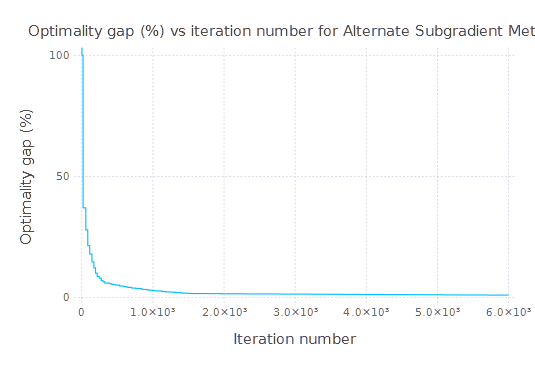

In [7]:
using Gadfly
curve1=abs((fBestTest-fMinValue)/fMinValue)*100
iters=[1:maxIter]
plot(
x=iters, 
y=curve1, 
Guide.ylabel("Optimality gap (%)"), # label for y-axis
Guide.xlabel("Iteration number"),  # label for x-axis
Guide.title("Optimality gap (%) vs iteration number for Alternate Subgradient Method"),  # a title
Geom.line
)